# Data Preprocessing

In [ ]:
import pickle
train_x,train_y = pickle.load(open('datauint8.pkl','rb'))

In [2]:
from sklearn.cross_validation import train_test_split
train_x,test_x,train_y,test_y = train_test_split(train_x,train_y,test_size=0.2,random_state=1120)

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import numpy as np
online_test_x = np.load("online_test_x.npy")

In [5]:
train_x = np.asarray(train_x, dtype=np.uint8)
train_y = np.asarray(train_y)
test_x = np.asarray(test_x, dtype=np.uint8)
test_y = np.asarray(test_y)
train_x = train_x.reshape(8000, 60, 101, 101)
test_x = test_x.reshape(2000, 60, 101, 101)
online_test_x = online_test_x.reshape(2000, 60, 101, 101)

In [6]:
from scipy import misc
# Resize image
# misc.imresize(train_x[i], (128, 128))
temp_list = []
for i in range(len(train_x)):
    for j in range(len(train_x[0])):
        temp_list.append(misc.imresize(train_x[i][j], (128, 128)))
train_x = temp_list
        
temp_list = []
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        temp_list.append(misc.imresize(test_x[i][j], (128, 128)))
test_x = temp_list
        
temp_list = []
for i in range(len(online_test_x)):
    for j in range(len(online_test_x[0])):
        temp_list.append(misc.imresize(online_test_x[i][j], (128, 128)))
online_test_x = temp_list

In [7]:
print(len(train_x), train_x[0].shape)
print(len(test_x), test_x[0].shape)
print(len(online_test_x), online_test_x[0].shape)

480000 (128, 128)
120000 (128, 128)
120000 (128, 128)


In [8]:
train_y = np.repeat(train_y, 60).reshape(8000 * 60, 1)
test_y = np.repeat(test_y, 60).reshape(2000 * 60, 1)

In [9]:
np.save("data/single_128/train_x", train_x)
np.save("data/single_128/test_x", test_x)
np.save("data/single_128/online_test_x", online_test_x)
np.save("data/single_128/train_y", train_y)
np.save("data/single_128/test_y", test_y)

In [2]:
import numpy as np
train_x = np.load("data/single_128/train_x.npy")
test_x = np.load("data/single_128/test_x.npy")
online_test_x = np.load("data/single_128/online_test_x.npy")
train_y = np.load("data/single_128/train_y.npy")
test_y = np.load("data/single_128/test_y.npy")

In [31]:
train_y = np.load("data/single_128/train_y.npy").reshape(8000, 60, 1)
test_y = np.load("data/single_128/test_y.npy").reshape(2000, 60, 1)
train_y_src = np.add.reduce(train_y, axis = 1) / 60.0
test_y_src = np.add.reduce(test_y, axis = 1) / 60.0
np.save("data/single_128/train_y_src", train_y_src)
np.save("data/single_128/test_y_src", test_y_src)

In [4]:
from sklearn.utils import shuffle
train_x, train_y = shuffle(train_x, train_y, random_state = 0)
test_x, test_y = shuffle(test_x, test_y, random_state = 0)

In [5]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((480000, 128, 128), (480000, 1), (120000, 128, 128), (120000, 1))

# Define CNN

In [6]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config)

In [7]:
n_input = 128 * 128
x = tf.placeholder(tf.uint8, shape=[None, 128, 128], name="x")
y_ = tf.placeholder(tf.float32, shape=[None, 1], name="y_")

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W ,strides=[1, 1, 1 ,1], padding="SAME")
def max_pool_4x4(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 4, 1],
                         strides=[1, 4, 4, 1], padding="SAME")

# First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 128, 128, 1])
float_x = tf.to_float(x_image)
h_conv1 = tf.nn.relu(conv2d(float_x, W_conv1) + b_conv1)
h_pool1 = max_pool_4x4(h_conv1)

# Secondary Convolution Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_4x4(h_conv2)

# Densely Connected Layer
W_fc1 = weight_variable([8 * 8 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8 * 8 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32, name="drop")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Read Layer
W_fc2 = weight_variable([1024, 1])
b_fc2 = bias_variable([1])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [8]:
loss = tf.reduce_sum(tf.square(y_conv - y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
sess.run(tf.global_variables_initializer())

In [10]:
saver = tf.train.Saver()
saver.restore(sess, "my_model/4_level_cnn_regression/cnn-140")

In [11]:
import sys 
train_size = 40
test_size = 100 
def get_batch_train(x, y, i, train_size):
    return x[i  * train_size: (i + 1) * train_size], y[i * train_size: (i + 1) * train_size]

def get_batch_test(x, y, i, test_size):
    return x[i * test_size: (i + 1) * test_size], y[i * test_size: (i + 1) * test_size]

total_train_iteration = len(train_x) / train_size
for i in range(141, 4000):
    if i % 10 == 0:
        saver = tf.train.Saver()
        save_path = saver.save(sess, "my_model/4_level_cnn_regression/cnn", global_step=i)
    
    print("start evaluate")    
    total_iteration = len(test_x) / test_size
    total_l2 = 0.0
    for test_batch_step in range(int(total_iteration)):
        test_batch_x, test_batch_y = get_batch_test(test_x, test_y, test_batch_step, test_size)
        total_l2 += loss.eval(feed_dict={
            x:test_batch_x, y_: test_batch_y, keep_prob: 1.0}, session=sess)
    
    print("step %d, test rsem %g"%(i, np.sqrt(total_l2 / float(len(test_x)))))
    
    for train_batch_step in range(int(total_train_iteration)):
        if train_batch_step % 400 == 0:
            str_log = ("%.2f %% " % (train_batch_step * 100 / total_train_iteration))
            sys.stdout.write('\r' + str_log)
        batch_x, batch_y = get_batch_train(train_x, train_y, train_batch_step, train_size)
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y, keep_prob: 0.5})

start evaluate
step 141, test rsem 11.5383
0.00 % 

KeyboardInterrupt: 

In [21]:
square = tf.square(y_conv - y_)
result_list = sess.run(square, feed_dict={x: test_x[0:5], y_: test_y[0:5], keep_prob: 1.0})
print(result_list)
print(sess.run(loss, feed_dict={x: test_x[0:5], y_: test_y[0:5], keep_prob: 1.0}))
print(np.add.reduce(result_list) / 5.0)
print(sess.run(y_conv, feed_dict={x: test_x[0:1], keep_prob: 1.0}))
print(test_y[0:1])

[[ 14.46087551]
 [ 82.48455811]
 [ 65.45223999]
 [  6.70091486]
 [ 37.25474167]]
206.353
[ 41.27066803]
[[ 24.40274429]]
[[ 20.6]]


# Test Data

In [32]:
import numpy as np
test_x = np.load("data/single_128/test_x.npy").reshape(2000, 60, 128, 128)
test_y_src = np.load("data/single_128/test_y_src.npy").reshape(2000, 1)

In [33]:
test_x = test_x.reshape(2000, 60, 128, 128)
test_y = np.load("test_y.npy")
result_list = []
for i in range(2000):
    result = sess.run(y_conv, feed_dict={x:test_x[i], keep_prob: 1.0})
    result_list.append(np.average(result))

In [34]:
np.sqrt(np.mean(np.square(np.array(result_list) - np.array(test_y_src))))

19.193011557027106

# Extract Feature

In [36]:
import numpy as np
train_x = np.load("data/single_128/train_x.npy").reshape(8000, 60, 128, 128)
train_y = np.load("data/single_128/train_y_src.npy").reshape(8000, 1)
test_x = np.load("data/single_128/test_x.npy").reshape(2000, 60, 128, 128)
test_y = np.load("data/single_128/test_y_src.npy").reshape(2000, 1)
online_test_x = np.load("data/single_128/online_test_x.npy").reshape(2000, 60, 128, 128)

In [44]:
def extract_feture(src_list):
    result_list = []
    for i in range(len(src_list)):
        result_list.append(sess.run(h_fc1, feed_dict={x: src_list[i]}))
    result_list = np.asarray(result_list)
    return result_list.reshape(len(src_list), 60, 1024)

feature_train_x = extract_feture(train_x)
feature_test_x = extract_feture(test_x)
feature_online_x = extract_feture(online_test_x)

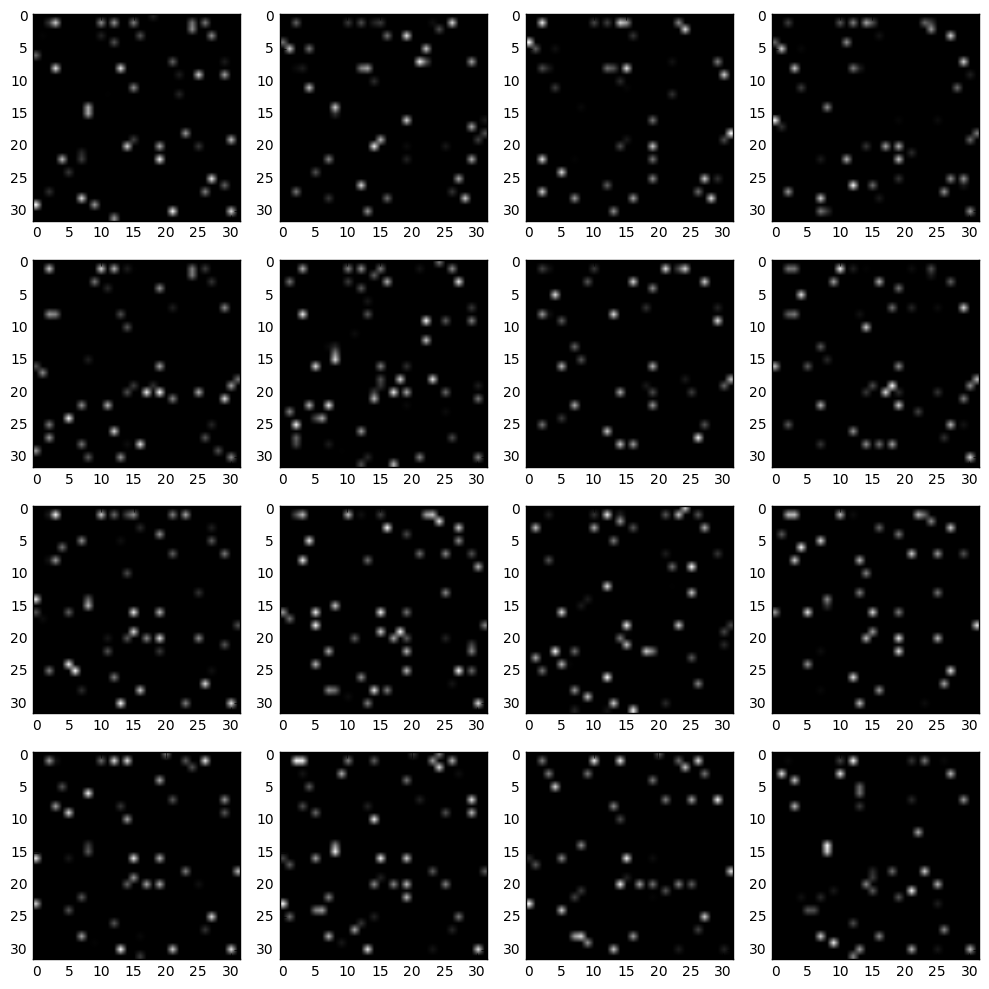

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
sample_data = feature_train_x[0]
f, axarr = plt.subplots(4, 4, figsize=(10,10))
for row in range(4):
    for line in range(4):
        src_image = sample_data[row * 15 + line].reshape(32,32)
        feature_map = (src_image / src_image.max()) * 255.0
        axarr[row][line].imshow(np.apply_along_axis(lambda x: np.repeat(x, 3), 1, feature_map).reshape(32,32,3))

plt.tight_layout()
plt.show()

In [46]:
np.save("data/single_128/cnn_regression/feature_train_x", feature_train_x)
np.save("data/single_128/cnn_regression/feature_test_x", feature_test_x)
np.save("data/single_128/cnn_regression/feature_online_x", feature_online_x)

# Boosting

In [1]:
import numpy as np
feature_train_x = np.load("data/single_128/cnn_regression/feature_train_x.npy")
train_y_src = np.load("data/single_128/train_y_src.npy")
feature_test_x = np.load("data/single_128/cnn_regression/feature_test_x.npy")
test_y_src = np.load("data/single_128/test_y_src.npy")
feature_online_x = np.load("data/single_128/cnn_regression/feature_online_x.npy")

In [2]:
feature_train_x = feature_train_x.reshape(8000, 1024 * 60)
feature_test_x = feature_test_x.reshape(2000, 1024 * 60)
feature_online_x = feature_online_x.reshape(2000, 1024 * 60)

In [5]:
train_y_src = np.asarray(train_y_src).reshape(8000)
test_y_src = np.asarray(test_y_src).reshape(2000)

In [6]:
np.where(feature_train_x > 1)

(array([   0,    0,    0, ..., 7999, 7999, 7999], dtype=int64),
 array([   18,    34,    35, ..., 61127, 61139, 61306], dtype=int64))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001823AD91978>]], dtype=object)

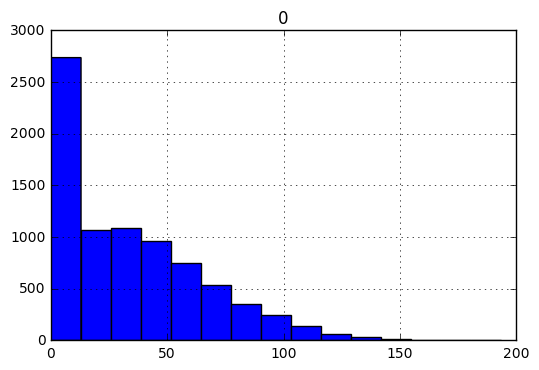

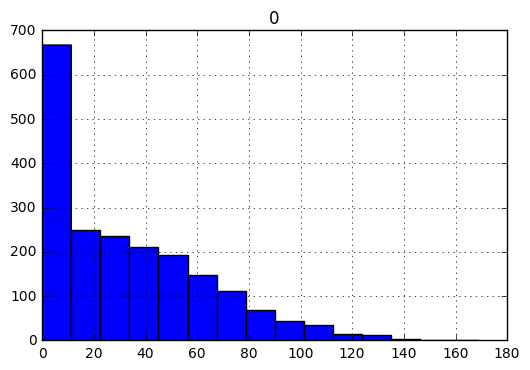

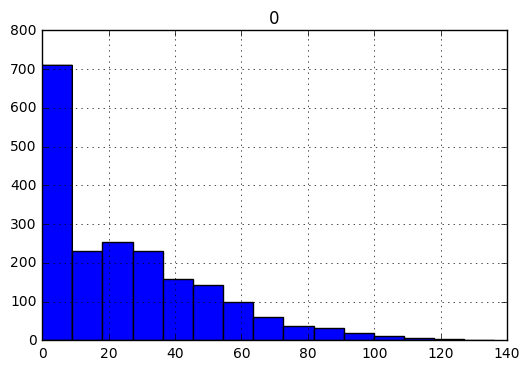

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 61127
import pandas as pd
pd.DataFrame(feature_train_x[:,index]).hist(bins =15)
pd.DataFrame(feature_test_x[:,index]).hist(bins =15)
pd.DataFrame(feature_online_x[:,index]).hist(bins =15)

In [13]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

lgb_train = lgb.Dataset(feature_train_x, train_y_src)
lgb_eval = lgb.Dataset(feature_test_x, test_y_src, reference=lgb_train)
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2'},
    'num_leaves': 37,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'lambda_l2': 1.0
}
reg = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=lgb_eval,
                early_stopping_rounds=10)

[1]	valid_0's l2: 254.449
Train until valid scores didn't improve in 10 rounds.
[2]	valid_0's l2: 247.36
[3]	valid_0's l2: 240.307
[4]	valid_0's l2: 233.721
[5]	valid_0's l2: 227.033
[6]	valid_0's l2: 221.068
[7]	valid_0's l2: 215.817
[8]	valid_0's l2: 210.504
[9]	valid_0's l2: 205.493
[10]	valid_0's l2: 200.803
[11]	valid_0's l2: 196.334
[12]	valid_0's l2: 192.166
[13]	valid_0's l2: 188.059
[14]	valid_0's l2: 184.075
[15]	valid_0's l2: 180.89
[16]	valid_0's l2: 177.171
[17]	valid_0's l2: 173.337
[18]	valid_0's l2: 169.374
[19]	valid_0's l2: 166.561
[20]	valid_0's l2: 163.907
[21]	valid_0's l2: 161.342
[22]	valid_0's l2: 158.781
[23]	valid_0's l2: 156.088
[24]	valid_0's l2: 153.739
[25]	valid_0's l2: 151.765
[26]	valid_0's l2: 149.997
[27]	valid_0's l2: 148.146
[28]	valid_0's l2: 146.433
[29]	valid_0's l2: 144.799
[30]	valid_0's l2: 143.038
[31]	valid_0's l2: 141.319
[32]	valid_0's l2: 139.612
[33]	valid_0's l2: 138.155
[34]	valid_0's l2: 136.818
[35]	valid_0's l2: 135.395
[36]	valid_0

In [14]:
reg_results = reg.predict(feature_online_x)
reg_results[reg_results < 0] = 0
with open("answer.csv", "w") as f:
    for result in reg_results:
        f.write(str(result) + "\n")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001823C9BCA58>]], dtype=object)

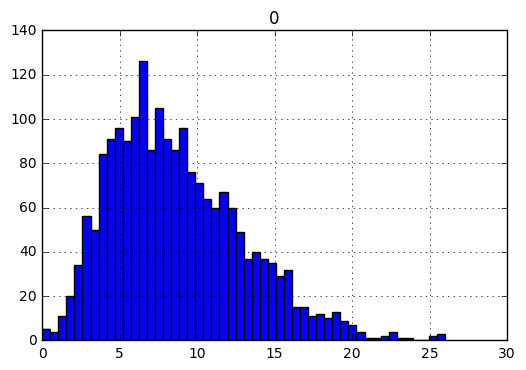

In [15]:
%matplotlib inline
pd.DataFrame(reg_results).hist(bins=50)

In [16]:
np.average(reg_results)

8.6955147416357033

In [17]:
reg_results = reg.predict(feature_test_x)
reg_results[reg_results < 0] = 0

In [18]:
np.average(reg_results)

16.098304860785355

In [27]:
print("max in\ntest:\t%f\ntrain:\t%f\nonline:\t%f\n" % (np.max(feature_test_x), np.max(feature_train_x), np.max(feature_online_x)))

max in
test:	281.453339
train:	314.690918
online:	279.808807



In [28]:
print("averge in\ntest:\t%f\ntrain:\t%f\nonline:\t%f\n" % (np.average(feature_test_x), np.average(feature_train_x), np.average(feature_online_x)))

averge in
test:	1.324542
train:	1.335028
online:	1.017943



In [42]:
feature_train_x = np.load("data/single_128/cnn_regression/feature_train_x.npy")
feature_test_x = np.load("data/single_128/cnn_regression/feature_test_x.npy")
feature_online_x = np.load("data/single_128/cnn_regression/feature_online_x.npy")
feature_train_x = feature_train_x.reshape(8000, 60, 1024)
feature_test_x = feature_test_x.reshape(2000, 60, 1024)
feature_online_x = feature_online_x.reshape(2000, 60, 1024)
feature_train_x = np.add.reduce(feature_train_x)
feature_test_x = np.add.reduce(feature_test_x)
feature_online_x = np.add.reduce(feature_online_x)

In [43]:
feature_train_x.shape, feature_test_x.shape, feature_online_x.shape

((60, 1024), (60, 1024), (60, 1024))

In [44]:
feature_train_x = np.add.reduce(feature_train_x)
feature_test_x = np.add.reduce(feature_test_x)
feature_online_x = np.add.reduce(feature_online_x)

In [45]:
feature_train_x.shape, feature_test_x.shape, feature_online_x.shape

((1024,), (1024,), (1024,))

In [46]:
feature_train_x = feature_train_x / (60.0 * 8000)
feature_test_x = feature_test_x / (60.0 * 2000)
feature_online_x = feature_online_x / (60.0 * 2000)

In [47]:
max(np.max(feature_train_x), np.max(feature_test_x), np.max(feature_online_x))

57.031456

In [50]:
axarr

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018180167160>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001818023C390>], dtype=object)

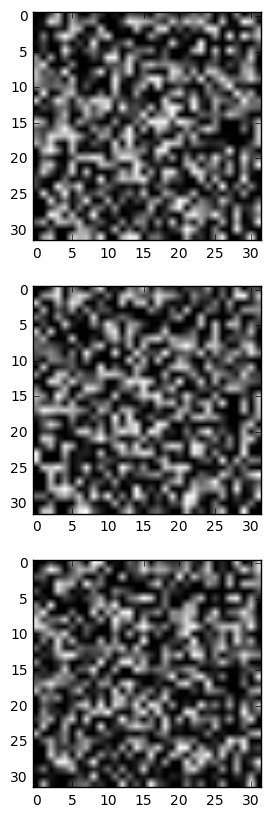

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
f, axarr = plt.subplots(3, 1, figsize=(10,10))

temp_image = feature_train_x.reshape(32, 32)
temp_image = (temp_image / 57.03) * 255.0
axarr[0].imshow(np.apply_along_axis(lambda x: np.repeat(x, 3), 1, temp_image).reshape(32,32,3))

temp_image = feature_test_x.reshape(32, 32)
temp_image = (temp_image / 57.03) * 255.0
axarr[1].imshow(np.apply_along_axis(lambda x: np.repeat(x, 3), 1, temp_image).reshape(32,32,3))

temp_image = feature_online_x.reshape(32, 32)
temp_image = (temp_image / 57.03) * 255.0
axarr[2].imshow(np.apply_along_axis(lambda x: np.repeat(x, 3), 1, temp_image).reshape(32,32,3))

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018180122898>]], dtype=object)

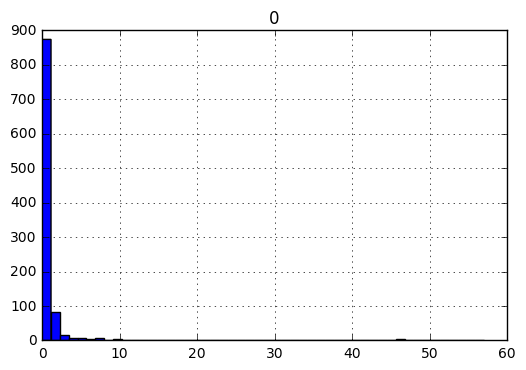

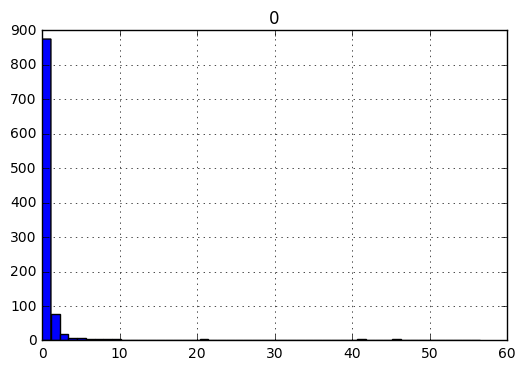

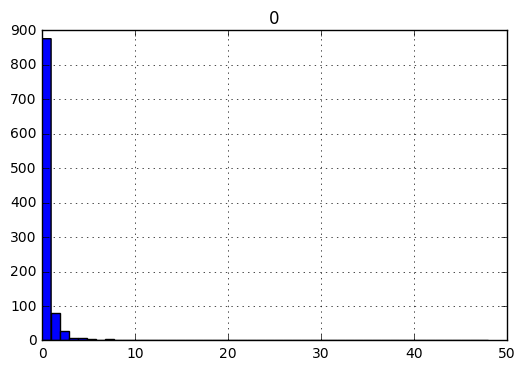

In [52]:
import pandas as pd
pd.DataFrame(feature_train_x).hist(bins=50)
pd.DataFrame(feature_test_x).hist(bins=50)
pd.DataFrame(feature_online_x).hist(bins=50)

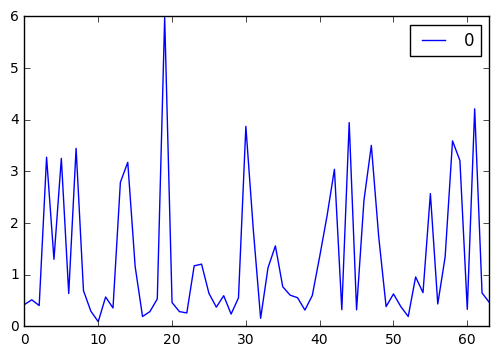

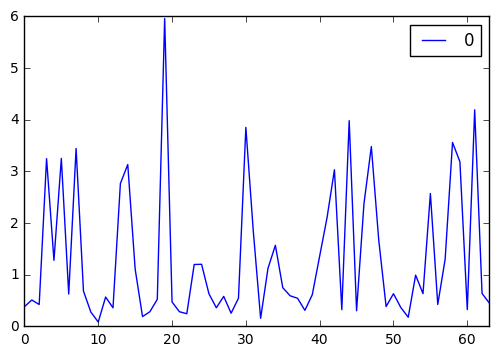

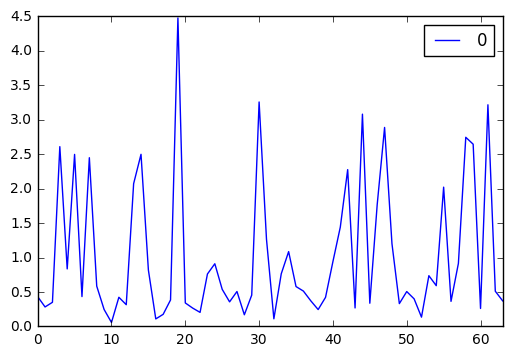

In [56]:
import pandas as pd
feature_train_x_plot = np.add.reduce(feature_train_x.reshape(16,64)) / 16.0
feature_test_x_plot = np.add.reduce(feature_test_x.reshape(16,64)) / 16.0
feature_online_x_plot = np.add.reduce(feature_online_x.reshape(16,64)) / 16.0
pd.DataFrame(feature_train_x_plot).plot()
pd.DataFrame(feature_test_x_plot).plot()
pd.DataFrame(feature_online_x_plot).plot()